In [1]:
import os

import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

/home/user/Projects/segmentation_baseline/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
GLOBAL_CONFIG = {
    'device': 'cpu',
    'IMG_W': 1024,
    'IMG_H': 1024,
    
    'batch_size': 1,
    'num_workers': 1,
    
    'csv_file': '/home/user/datasets/hubmap-organ-segmentation/test.csv',
    'images_dir': '/home/user/datasets/hubmap-organ-segmentation/test_images',
}

In [3]:
models = [
    {
        'model': smp.Unet(encoder_name="resnext50_32x4d", classes=1),
        'ckpt_path': './lightning_logs/version_2/checkpoints/best-epoch=181-iou_valid=0.71-dice_valid=0.71.ckpt',
        'name': 'unet_resnet34',
        'use_tta': False,
        'weight': 1.0,
    },
]

In [4]:
for item in models:
    ckpt = torch.load(item['ckpt_path'])
    
    state_dict = {}
    for name in ckpt['state_dict']:
        state_dict[name.replace('model.', '')] = ckpt['state_dict'][name]
    
    item['model'].load_state_dict(state_dict)
    item['model'] = item['model'].eval().to(GLOBAL_CONFIG['device'])

In [5]:
def show_image(image, figsize=(5, 5), cmap=None, title='', xlabel=None, ylabel=None, axis=False):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis(axis)
    plt.show();
    
def show_images(images, figsize=(5, 5), title='', cmap=None, xlabel=None, ylabel=None, axis=False):
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    for ax, img in zip(axes, images):
        ax.imshow(img, cmap=cmap)
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.axis(axis)
    plt.show();
    
def preprocess_image(image, img_w=None, img_h=None):
    img = image.copy()
    if img_w and img_h:
        img = cv2.resize(img, (img_w, img_h))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    img = torch.from_numpy(img).permute(2, 0, 1)
    return img

def process_img2np(image):
    img = image.cpu().clone()
    img = img.permute(1, 2, 0).numpy() * 255
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape).T

class HubmapInferenceDataset(Dataset):
    def __init__(self, images_dir, csv_path, img_w=None, img_h=None, augs=None):
        self.df = pd.read_csv(csv_path)
        self.images_dir = images_dir
        self.img_w = img_w
        self.img_h = img_h
        self.augs = augs
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        info = self.df.iloc[index]
        img_name = '{}.tiff'.format(info['id'])
        img_path = os.path.join(self.images_dir, img_name)
        
        image = cv2.imread(img_path)
        img_h, img_w = image.shape[:2]
        
        if self.augs is not None:
            item = self.augs(image=image, mask=mask)
            image = item['image']

        image = preprocess_image(image, img_w=self.img_w, img_h=self.img_h)

        return {
            'image': image, 
            'id': info['id'],
            'orig_h': img_h,
            'orig_w': img_w,
        }

In [6]:
test_dataset = HubmapInferenceDataset(
    GLOBAL_CONFIG['images_dir'], 
    GLOBAL_CONFIG['csv_file'], 
    img_w=GLOBAL_CONFIG['IMG_W'], 
    img_h=GLOBAL_CONFIG['IMG_H']
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=GLOBAL_CONFIG['batch_size'], 
    num_workers=GLOBAL_CONFIG['num_workers'], 
    shuffle=False, 
    drop_last=False)

In [7]:
submission_df = pd.DataFrame(columns=['id', 'rle'])

for n, batch in enumerate(tqdm(test_loader)):
    predict = torch.zeros(1, GLOBAL_CONFIG['IMG_H'], GLOBAL_CONFIG['IMG_W'], dtype=torch.float32, device='cpu')

    for item in models:
        with torch.no_grad():
            pr = item['model'](batch['image'].to(GLOBAL_CONFIG['device']))
            pr = F.sigmoid(pr.cpu().detach())[0]
            predict += pr * item['weight']

    mask = predict.round().numpy()[0]
    mask = cv2.resize(mask, (batch['orig_w'][0].item(), batch['orig_h'][0].item()), interpolation=cv2.INTER_NEAREST)
    
    row = {
        'id': batch['id'][0].item(),
        'rle': mask2rle(mask),
    }
    submission_df = submission_df.append(row, ignore_index=True)

submission_df.to_csv('submission.csv', index=False)

  0%|                                                     | 0/1 [00:00<?, ?it/s]/home/user/Projects/segmentation_baseline/venv/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/tmp/ipykernel_646459/3594919173.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  submission_df = submission_df.append(row, ignore_index=True)
100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.14s/it]


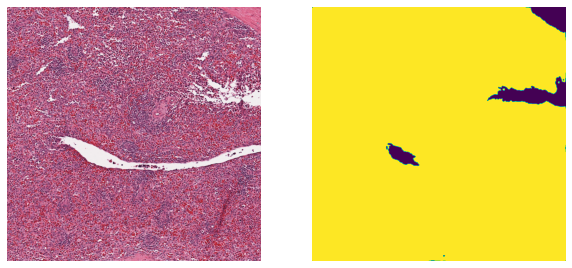

In [8]:
rle_mask = rle2mask(submission_df.iloc[-1]['rle'], (batch['orig_w'][0].item(), batch['orig_h'][0].item()))
image = process_img2np(batch['image'][0])
show_images([image, rle_mask*255], figsize=(10, 5))